In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt


In [2]:

class DruidStatCalculator():
    def __init__(self,current_stats):
        self.old_stats=current_stats
        self.current_stats=current_stats
        self.current_damage=self.overall_damage(current_stats)
        self.new_stats=copy.copy(self.current_stats)

    def ArP_multiplier(self,stats, FF=True, sunder=False, mob_armor=10643):
        armor_pen=stats['Armor Pen']
        if FF:
            mob_armor*=0.95
        if sunder:
            mob_armor*=0.8
        armor_constant=15232.5
        ArP_eff_cap=(armor_constant+mob_armor)/3
        armor_removed=min(ArP_eff_cap*armor_pen/1400,ArP_eff_cap)
        remaining_armor=mob_armor-armor_removed
        frac_damage_taken=armor_constant/(armor_constant+remaining_armor)
        default_damage_taken=armor_constant/(armor_constant+mob_armor)
        multiplier=frac_damage_taken/default_damage_taken
        return multiplier

    def hit_multiplier(self, stats, draenei_in_party=True):
        hit_rating=stats['Hit Rating']
        hit_chance=0.92
        if draenei_in_party:
            hit_chance+=0.01
        hit_chance+=hit_rating/32.79/100
        return min(hit_chance,1)

    def expertise_multiplier(self, stats, primal_precision=True):
        expertise_rating = stats['Expertise Rating']
        land_chance=0.92
        if primal_precision:
            land_chance+=0.04
        land_chance+=expertise_rating/32.79/100
        return min(land_chance,1)

    def crit_multiplier(self, stats, crit_value=2.5):
        crit_chance = stats['Crit Chance']
        #crits actually only do 2.2x damage, but I've set this slightly higher to subjectively account for extra combo points
        crit_chance=min(crit_chance,1)
        return crit_chance*crit_value+(1-crit_chance)
    
    def overall_multiplier(self, stats):
        return self.ArP_multiplier(stats)*self.hit_multiplier(stats)*self.expertise_multiplier(stats)*self.crit_multiplier(stats)

    def overall_damage(self, stats):
        return self.overall_multiplier(stats)*stats['Attack Power']
    
    def modify_stats(self, stat_changes, hotw=1.1893):
        #assumes heart of the wild and blessing of kings
        self.reset_stats()
        self.new_stats['Attack Power']+= 2*hotw*stat_changes['Strength'] + hotw*stat_changes['Agility'] + stat_changes['Attack Power']
        self.new_stats['Armor Pen'] += stat_changes['Armor Pen']
        self.new_stats['Hit Rating'] += stat_changes['Hit Rating']
        self.new_stats['Expertise Rating'] += stat_changes['Expertise Rating']
        self.new_stats['Crit Chance'] += stat_changes['Crit Rating']/45.91/100 + hotw*stat_changes['Agility']/83.33/100

    def damage_change(self,stat_changes):
        self.modify_stats(stat_changes)
        return self.overall_damage(self.new_stats)/self.current_damage
    
    def best_stat(self,change_amount=20):
        no_changes={
            'Agility' : 0,
            'Strength' : 0,
            'Armor Pen' : 0,
            'Hit Rating' : 0,
            'Expertise Rating' : 0,
            'Crit Rating': 0,
            'Attack Power' : 0}
        corresponding_damages=[]
        stat_names=[]
        for stat in no_changes:
            stat_names.append(stat)
            test_change=copy.copy(no_changes)
            test_change[stat]+=change_amount
            corresponding_damages.append(self.damage_change(test_change))
        return np.array(stat_names)[corresponding_damages==np.max(corresponding_damages)][0] 
    
    
            
    def reset_stats(self):
        self.current_stats=copy.copy(self.old_stats)
        self.new_stats=copy.copy(self.old_stats)
    
    def stat_priority(self,factor_desired=1.005,maxcheck=1000,normalize=True):
        no_changes={
            'Agility' : 0,
            'Strength' : 0,
            'Armor Pen' : 0,
            'Hit Rating' : 0,
            'Expertise Rating' : 0,
            'Crit Rating': 0,
            'Attack Power' : 0}
        stat_names=[]
        weights=[]
        for stat in no_changes:
            #check how much of each stat is necessary to reach factor_desired. Inverse of this is the weight.
            stat_names.append(stat)
            test_change=copy.copy(no_changes)
            corresponding_damage=1.0
            while corresponding_damage<factor_desired:
                test_change[stat]+=1
                corresponding_damage=self.damage_change(test_change)
                weight=1/test_change[stat]
                if test_change[stat]>=maxcheck:
                    weight=0
                    break
            weights.append(weight)
        stat_names=np.array(stat_names)
        weights=np.array(weights)
        weights=weights/weights[stat_names=='Attack Power']
        return dict(zip(stat_names,weights))
    
    
    def plot_stat_prio(self,ax):
        stat_prio=self.stat_priority()
        stat_names = list(stat_prio.keys())
        weights = list(stat_prio.values())

        # Create bar plot
        ax.bar(stat_names, weights)

        # Adding titles and labels
        # plt.xlabel('Stat')
        ax.set_ylabel('Weights')
        ax.set_title('Stat Priority')
        ax.tick_params(axis='x', rotation=45)
        # plt.show()
    
    def update_stats(self,stats):
        self.__init__(stats)
        
        
        


In [3]:
stat_changes={
    'Agility' : -67,
    'Strength' : 84,
    'Armor Pen' : 25,
    'Hit Rating' : 45,
    'Expertise Rating' : 0,
    'Crit Rating': -38,
    'Attack Power' : -89}

# stat_changes={
#     'Agility' : 1,
#     'Strength' : 0,
#     'Armor Pen' : 102,
#     'Hit Rating' : -74,
#     'Expertise Rating' : 0,
#     'Crit Rating': -91,
#     'Attack Power' : 12+187*1.1}

current_stats={
    'Armor Pen' : 639,
    'Hit Rating' : 360,
    'Expertise Rating' : 10,
    'Attack Power' : 8435,
    'Crit Chance': 0.6200}

calc=DruidStatCalculator(current_stats)
print('Percent damage change from stat change:')
percent_change=(calc.damage_change(stat_changes)-1)*100
print(f'{percent_change:.2f} %')


Percent damage change from stat change:
-0.32 %


Unbuffed best stat:  Expertise Rating
On trinket procs best stat:  Expertise Rating
If all proc together, damage increases by 54.76 %


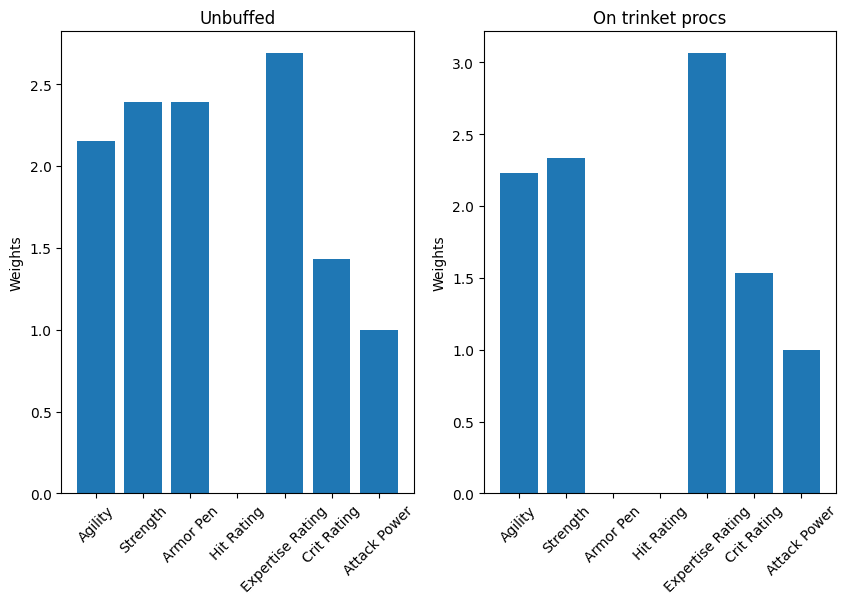

In [4]:
#compare stat priority with and without trinket procs
calc.update_stats(current_stats)
print('Unbuffed best stat: ', calc.best_stat())
f,ax=plt.subplots(1,2,figsize=(10,6))
calc.plot_stat_prio(ax=ax[0])
unbuffed_damage=calc.current_damage
ax[0].set_title('Unbuffed')

procs={
    'Agility' : 650,
    'Strength' : 0,
    'Armor Pen' : 751,
    'Hit Rating' : 0,
    'Expertise Rating' : 0,
    'Crit Rating': 0,
    'Attack Power' : 400}

calc.modify_stats(procs)
procced_stats=calc.new_stats
calc.update_stats(procced_stats)
trinket_damage=calc.current_damage

print('On trinket procs best stat: ', calc.best_stat())
print(f'If all proc together, damage increases by {(trinket_damage/unbuffed_damage-1)*100:.2f} %')
# print(calc.stat_priority())
calc.plot_stat_prio(ax=ax[1])
ax[1].set_title('On trinket procs')
plt.show()

In [5]:
#normalized by factor of 0.61 for pawn addon
calc.update_stats(current_stats)
weights=[value*0.61 for value in list(calc.stat_priority().values())]
stat_names=list(calc.stat_priority().keys())
print(dict(zip(stat_names,weights)))

{'Agility': 1.3115, 'Strength': 1.4572222222222222, 'Armor Pen': 1.4572222222222222, 'Hit Rating': 0.0, 'Expertise Rating': 1.639375, 'Crit Rating': 0.8743333333333333, 'Attack Power': 0.61}
